In [47]:
library(dplyr)
library(ggplot2)
library(corrplot)
library(reshape2)
library(zoo)
library(urca)
library(tseries)
library(rugarch)
library(lmtest)
library(stats) 
library(foreach)
library(doParallel)
library(fGarch)


Warning message:
"package 'rugarch' was built under R version 3.6.3"Loading required package: parallel

Attaching package: 'rugarch'

The following object is masked from 'package:stats':

    sigma

Warning message:
"package 'lmtest' was built under R version 3.6.3"Warning message:
"package 'foreach' was built under R version 3.6.3"Warning message:
"package 'doParallel' was built under R version 3.6.3"Loading required package: iterators
Warning message:
"package 'iterators' was built under R version 3.6.3"Warning message:
"package 'fGarch' was built under R version 3.6.3"Loading required package: timeDate
Warning message:
"package 'timeDate' was built under R version 3.6.3"Loading required package: timeSeries
Warning message:
"package 'timeSeries' was built under R version 3.6.3"
Attaching package: 'timeSeries'

The following object is masked from 'package:zoo':

    time<-

Loading required package: fBasics
Warning message:
"package 'fBasics' was built under R version 3.6.3"

In [2]:
directory <- "C:/Users/LENOVO/Desktop/stat/global/"

years <- c("2008", "2009", "2010", "2011", "2012", "2013", "2014", "2015",
           "2016", "2017", "2018", "2019", "2020", "2021", "2022", "2023")

data_list <- list()
for (year in years) {
  file_path <- paste0(directory, year, "_Global_Markets_Data.csv")
  data <- read.csv(file_path, header = TRUE)
  data_list[[year]] <- data
}

all_data <- do.call(rbind, data_list)

In [3]:
head(all_data)

,Ticker,Date,Open,High,Low,Close,Adj.Close,Volume
2008.1,^NYA,2008-08-01,8438.71,8452.01,8356.43,8379.15,8379.15,4684870000
2008.2,^IXIC,2008-08-01,2326.83,2328.95,2286.41,2310.96,2310.96,2312140000
2008.3,^FTSE,2008-08-01,5411.90,5411.90,5321.30,5354.70,5354.70,1341947000
2008.4,^NSEI,2008-08-01,4331.60,4422.95,4235.70,4413.55,4413.55,0
2008.5,^BSESN,2008-08-01,14064.26,14682.33,14032.87,14656.69,14656.69,40200
2008.6,^N225,2008-08-01,13276.57,13294.17,13039.21,13094.59,13094.59,135000000


Our dataset encompasses daily price and volume data from several major global stock indices and commodities for the period of 2008 to 2023. The following financial instruments are included:

- ^NYA: NYSE Composite (New York Stock Exchange)
- ^IXIC: NASDAQ Composite
- ^FTSE: FTSE 100 Index (Financial Times Stock Exchange, UK)
- ^NSEI: Nifty 50 (National Stock Exchange of India)
- ^BSESN: BSE SENSEX (Bombay Stock Exchange, India)
- ^N225: Nikkei 225 (Japan)
- 000001.SS: SSE Composite Index (Shanghai Stock Exchange)
- ^N100: Euronext 100 (European Stock Exchange)
- ^DJI: Dow Jones Industrial Average (USA)
- ^GSPC: S&P 500 Index (USA)
- GC=F: Gold Futures
- CL=F: Crude Oil Futures

For each ticker symbol, the following columns are included:

- Date: The date of the data point.
- Open: The opening price for the given date.
- High: The highest price for the given date.
- Low: The lowest price for the given date.
- Close: The closing price for the given date.
- Adj Close: The adjusted closing price for the given date.
- Volume: The number of shares traded on the given date.

In [4]:
ticker_labels <- data.frame(
  Ticker = c("^NYA", "^IXIC", "^FTSE", "^NSEI", "^BSESN", "^N225", "000001.SS", "^N100", "^DJI", "^GSPC", "GC=F", "CL=F"),
  Description = c("New York Stock", "NASDAQ Composite", "United Kingdom", "India National stock", "Bombay stock india", "Japan", "Shanghai", "Europe", "Dow Jones Industrial Average", "USA stock", "Gold Futures", "Crude Oil Futures")
)

all_data <- left_join(all_data, ticker_labels, by = "Ticker")

In [5]:
all_data <- all_data %>%
  select(-Ticker)

In [6]:
all_data <- all_data %>%
  select(Description, everything())

For a volatility and investor behavior analysis, the primary focus should typically be on the "Close" price column, which represents the closing price of the stock on each trading day and 'Volume' which represents The number of shares traded on the given date, in that case Open , High  and Low columns will be deleted

<b>Close Price:</b> The "Close" price is the final trading price of a security at the end of a trading session. It represents the last price at which a trade occurred before the market closed. The "Close" price is often used for general analysis and visualization of stock prices.

<b>Adjusted Close Price:</b> The "Adj Close" price is the closing price adjusted for factors like dividends, stock splits, and other corporate actions. It accounts for these adjustments to provide a more accurate representation of the investment's value over time. The "Adj Close" price is particularly important for long-term analysis and for tracking the actual returns an investor would have received.

After financial research, it's common to use the "Adj Close" price when conducting studies that require precise return calculations, such as calculating historical volatility, risk-adjusted returns, or portfolio performance over extended periods. 

In [7]:
all_data$Open <- NULL
all_data$High <- NULL
all_data$Low <- NULL
all_data$Close <- NULL

## Handle missing values:

In [8]:
count_missing_values <- function(data) {
  sum(is.na(data))
}
missing_values_count <- sapply(all_data, count_missing_values)
print(missing_values_count)

Description        Date   Adj.Close      Volume 
          0           0           0           0 


It looks like there are no missing values (NA) in the datasets. Having no missing values is ideal for conducting analyses as it ensures that we have complete data for all the observations.

- The "performance" column calculated represents the daily returns for the index based on the provided formula. Each value in the "performance" column represents the percentage change in the index's price from one day to the next, expressed as a logarithmic return.

formula:
Ri,t = 100 × [ln(Pi,t / Pi,t−1)]

Where:

Ri,t is the daily return (performance) for the index on day t.
Pi,t is the price of the index at the end of day t.
Pi,t−1 is the price of the index at the end of the previous day (day t - 1).
ln denotes the natural logarithm.
The result is multiplied by 100 to express the return as a percentage.

In [9]:
calculate_performance <- function(data) {
  data %>%
    mutate(Performance = 100 * log(Adj.Close / lag(Adj.Close)))
}

result <- all_data %>%
  group_by(Description) %>%
  arrange(Description, Date) %>%
  calculate_performance()
print(result)

Warning message in log(Adj.Close/lag(Adj.Close)):
"NaNs produced"

# A tibble: 44,900 x 5
# Groups:   Description [12]
   Description        Date       Adj.Close Volume Performance
   <fct>              <fct>          <dbl>  <dbl>       <dbl>
 1 Bombay stock india 2008-08-01    14657.  40200      NA    
 2 Bombay stock india 2008-08-04    14578.  24800      -0.539
 3 Bombay stock india 2008-08-05    14961.  35600       2.59 
 4 Bombay stock india 2008-08-06    15074.  32600       0.749
 5 Bombay stock india 2008-08-07    15117.  25800       0.290
 6 Bombay stock india 2008-08-08    15168.  21000       0.334
 7 Bombay stock india 2008-08-11    15504.  26200       2.19 
 8 Bombay stock india 2008-08-12    15212.  27000      -1.90 
 9 Bombay stock india 2008-08-13    15093.  19200      -0.785
10 Bombay stock india 2008-08-14    14724.  22000      -2.47 
# ... with 44,890 more rows


In [10]:
missing_values_count <- sapply(result, count_missing_values)
print(missing_values_count)

Description        Date   Adj.Close      Volume Performance 
          0           0           0           0          14 


In [11]:
na_positions <- which(is.na(result$Performance))
print(result[na_positions, ])

# A tibble: 14 x 5
# Groups:   Description [12]
   Description                  Date       Adj.Close     Volume Performance
   <fct>                        <fct>          <dbl>      <dbl>       <dbl>
 1 Bombay stock india           2008-08-01   14657.       40200          NA
 2 Crude Oil Futures            2008-08-01     125.      277311          NA
 3 Crude Oil Futures            2020-04-20     -37.6     247947         NaN
 4 Crude Oil Futures            2020-04-21      10.0    2288230         NaN
 5 Dow Jones Industrial Average 2008-08-01   11326.   189700000          NA
 6 Europe                       2008-08-01     747.   308081600          NA
 7 Gold Futures                 2008-08-01     909         1834          NA
 8 India National stock         2008-08-01    4414.           0          NA
 9 Japan                        2008-08-01   13095.   135000000          NA
10 NASDAQ Composite             2008-08-01    2311.  2312140000          NA
11 New York Stock               2008-08-

- <b>NaN Values in Crude Oil Market:</b> The presence of NaN values is due to the logarithmic return calculation. If the "Adj.Close" values for certain days are zero or negative, the logarithmic calculation will result in NaN (Not-a-Number) values.

When the "Adj.Close" value of a financial asset, such as a stock or commodity, becomes negative or zero after being positive, it typically indicates a significant change in the value of that asset


In the context of your calculation for the "Performance" column, where calculating daily returns based on the logarithmic difference in the "Adj.Close" values, a significant decrease from a positive value to zero or negative value could result in a very large negative value for the "Performance" on that day. This large negative value would indicate a substantial loss in the value of the asset from the previous day.

Replacing NaN values with a fixed value of -100 is a straightforward approach that allows you to signify the absence of valid data or an extreme negative performance when the logarithmic calculation results in NaN due to zero or negative "Adj.Close" values

In [12]:
result$Performance[is.nan(result$Performance)] <- -100
print(result)

# A tibble: 44,900 x 5
# Groups:   Description [12]
   Description        Date       Adj.Close Volume Performance
   <fct>              <fct>          <dbl>  <dbl>       <dbl>
 1 Bombay stock india 2008-08-01    14657.  40200      NA    
 2 Bombay stock india 2008-08-04    14578.  24800      -0.539
 3 Bombay stock india 2008-08-05    14961.  35600       2.59 
 4 Bombay stock india 2008-08-06    15074.  32600       0.749
 5 Bombay stock india 2008-08-07    15117.  25800       0.290
 6 Bombay stock india 2008-08-08    15168.  21000       0.334
 7 Bombay stock india 2008-08-11    15504.  26200       2.19 
 8 Bombay stock india 2008-08-12    15212.  27000      -1.90 
 9 Bombay stock india 2008-08-13    15093.  19200      -0.785
10 Bombay stock india 2008-08-14    14724.  22000      -2.47 
# ... with 44,890 more rows


In [13]:
na_positions <- which(is.na(result$Performance))
print(result[na_positions, ])

# A tibble: 12 x 5
# Groups:   Description [12]
   Description                  Date       Adj.Close     Volume Performance
   <fct>                        <fct>          <dbl>      <dbl>       <dbl>
 1 Bombay stock india           2008-08-01    14657.      40200          NA
 2 Crude Oil Futures            2008-08-01      125.     277311          NA
 3 Dow Jones Industrial Average 2008-08-01    11326.  189700000          NA
 4 Europe                       2008-08-01      747.  308081600          NA
 5 Gold Futures                 2008-08-01      909        1834          NA
 6 India National stock         2008-08-01     4414.          0          NA
 7 Japan                        2008-08-01    13095.  135000000          NA
 8 NASDAQ Composite             2008-08-01     2311. 2312140000          NA
 9 New York Stock               2008-08-01     8379. 4684870000          NA
10 Shanghai                     2008-08-01     2802.      49200          NA
11 United Kingdom               2008-08-

Since there's no previous day's data before 2008-08-01 to calculate the performance, removing those rows with NA values from the "Performance" column makes sense. This ensures that the analysis is consistent and accurate, and it acknowledges that the calculation cannot be performed in those cases.

In [14]:
data <- na.omit(result)
print(data)

# A tibble: 44,888 x 5
# Groups:   Description [12]
   Description        Date       Adj.Close Volume Performance
   <fct>              <fct>          <dbl>  <dbl>       <dbl>
 1 Bombay stock india 2008-08-04    14578.  24800      -0.539
 2 Bombay stock india 2008-08-05    14961.  35600       2.59 
 3 Bombay stock india 2008-08-06    15074.  32600       0.749
 4 Bombay stock india 2008-08-07    15117.  25800       0.290
 5 Bombay stock india 2008-08-08    15168.  21000       0.334
 6 Bombay stock india 2008-08-11    15504.  26200       2.19 
 7 Bombay stock india 2008-08-12    15212.  27000      -1.90 
 8 Bombay stock india 2008-08-13    15093.  19200      -0.785
 9 Bombay stock india 2008-08-14    14724.  22000      -2.47 
10 Bombay stock india 2008-08-18    14646.  19600      -0.535
# ... with 44,878 more rows


## Time Series Visualisations

In [15]:
unique_markets <- unique(data$Description)
for (desc in unique_markets) {
  subset_df <- data[data$Description == desc, ]
  print(paste("Market:", desc, " - Rows:", nrow(subset_df)))
}

[1] "Market: Bombay stock india  - Rows: 3675"
[1] "Market: Crude Oil Futures  - Rows: 3770"
[1] "Market: Dow Jones Industrial Average  - Rows: 3772"
[1] "Market: Europe  - Rows: 3834"
[1] "Market: Gold Futures  - Rows: 3768"
[1] "Market: India National stock  - Rows: 3668"
[1] "Market: Japan  - Rows: 3663"
[1] "Market: NASDAQ Composite  - Rows: 3772"
[1] "Market: New York Stock  - Rows: 3772"
[1] "Market: Shanghai  - Rows: 3639"
[1] "Market: United Kingdom  - Rows: 3783"
[1] "Market: USA stock  - Rows: 3772"


In [16]:
data$Date <- as.Date(data$Date)

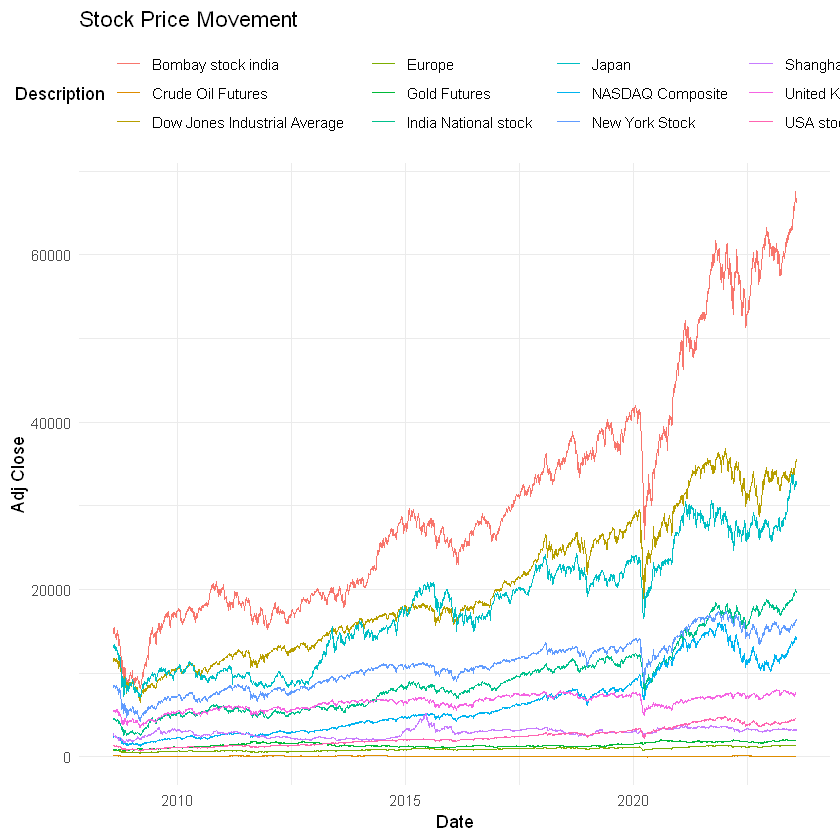

In [17]:
ggplot(data, aes(x = Date, y = `Adj.Close`, color = Description)) +
  geom_line() +
  labs(title = "Stock Price Movement", x = "Date", y = "Adj Close") +
  theme_minimal() +
  theme(legend.position = "top") 

In [18]:
data <- data %>%
  arrange(Date) %>%
  mutate(Diff = `Adj.Close` - lag(`Adj.Close`))
max_diff_row <- data %>% filter(Diff == max(Diff, na.rm = TRUE))
fall_date <- max_diff_row$Date
print(fall_date)

 [1] "2015-06-30" "2020-03-13" "2020-03-24" "2020-03-24" "2020-03-24"
 [6] "2020-03-24" "2020-03-25" "2020-04-07" "2020-04-07" "2020-04-21"
[11] "2022-03-09" "2022-11-10"


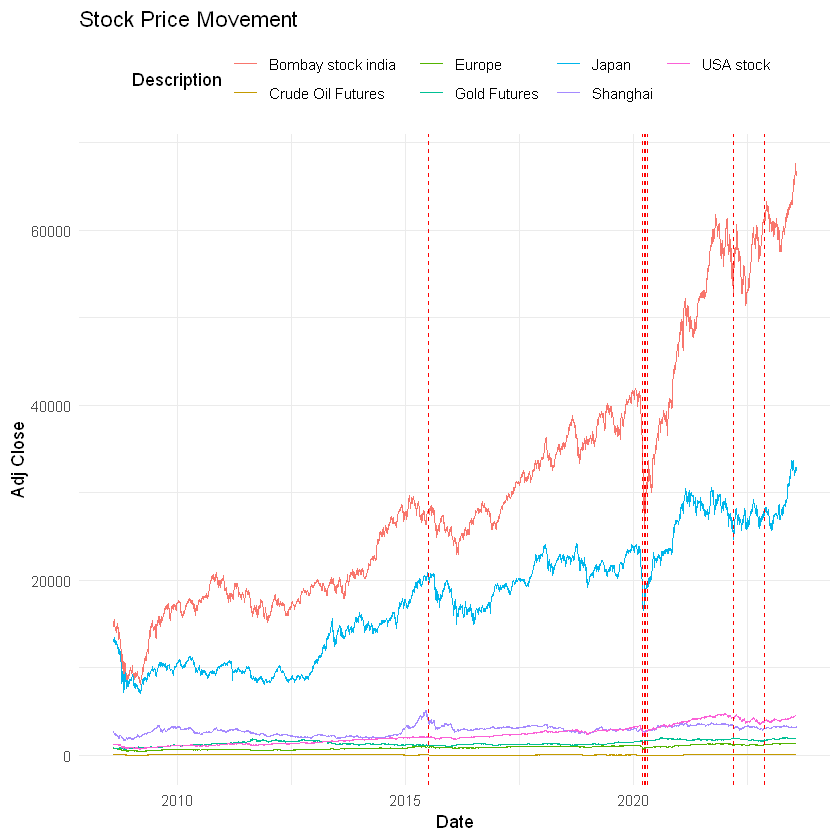

In [39]:
ggplot(data, aes(x = Date, y = `Adj.Close`, color = Description)) +
  geom_line() +
  labs(title = "Stock Price Movement", x = "Date", y = "Adj Close") +
  theme_minimal() +
  theme(legend.position = "top") +
  
  geom_vline(xintercept = as.numeric(as.Date(c("2015-06-30", "2020-03-13", "2020-03-24", "2020-03-24", "2020-03-24",
                                               "2020-03-24", "2020-03-25", "2020-04-07", "2020-04-07",
                                               "2020-04-21", "2022-03-09", "2022-11-10"))),
             linetype = "dashed", color = "red")

the date of structural failure is indicated by the vertical line.The most significant fialure is indicated from 2020-03-09 to 2020-04-21 
In addition, we can divide the study period into two sub-periods:
- Quiet period: 2008-08-01 to 2020-03-09 and from 2020-04-21 to 2023-07-28 .
- Crisis period: from 2020-03-09 to 2020-04-21.

In [29]:
summary_stats <- data %>%
  summarise(
    Mean = mean(`Performance`, na.rm = TRUE),
    Median = median(`Performance`, na.rm = TRUE),
    SD = sd(`Performance`, na.rm = TRUE),
    Min = min(`Performance`, na.rm = TRUE),
    Max = max(`Performance`, na.rm = TRUE)
  )

print(summary_stats)

# A tibble: 12 x 6
   Description                      Mean Median    SD     Min   Max
   <fct>                           <dbl>  <dbl> <dbl>   <dbl> <dbl>
 1 Bombay stock india            0.0410  0.0628  1.30  -14.1  16.0 
 2 Crude Oil Futures            -0.0488  0.0904  3.63 -100    32.0 
 3 Dow Jones Industrial Average  0.0303  0.0564  1.24  -13.8  10.8 
 4 Europe                        0.0164  0.0645  1.30  -12.8  10.3 
 5 Gold Futures                  0.0204  0.0362  1.11   -9.82  8.64
 6 India National stock          0.0407  0.0636  1.29  -13.9  16.3 
 7 Japan                         0.0250  0.0717  1.48  -12.1  13.2 
 8 NASDAQ Composite              0.0483  0.104   1.45  -13.1  11.2 
 9 New York Stock                0.0177  0.0630  1.32  -12.6  11.5 
10 Shanghai                      0.00430 0.0499  1.42   -8.87  9.03
11 United Kingdom                0.00958 0.0571  1.17  -11.5   9.38
12 USA stock                     0.0342  0.0687  1.30  -12.8  11.0 


Get a statistical overview of Performance time series by calculating various summary statistics, such as mean, median, standard deviation, minimum, and maximum values

### corrlartion between markets

When two markets have a strong positive correlation, it means that they tend to move together in a very similar manner. In such cases, having both markets in the analysis or investment portfolio might not provide much diversification, as their movements are highly correlated.
In order to reduce redundancy and simplify your analysis, we can consider removing one of the markets with a strong positive correlation. This would allow you to focus on markets that provide more unique information or diversification potential.

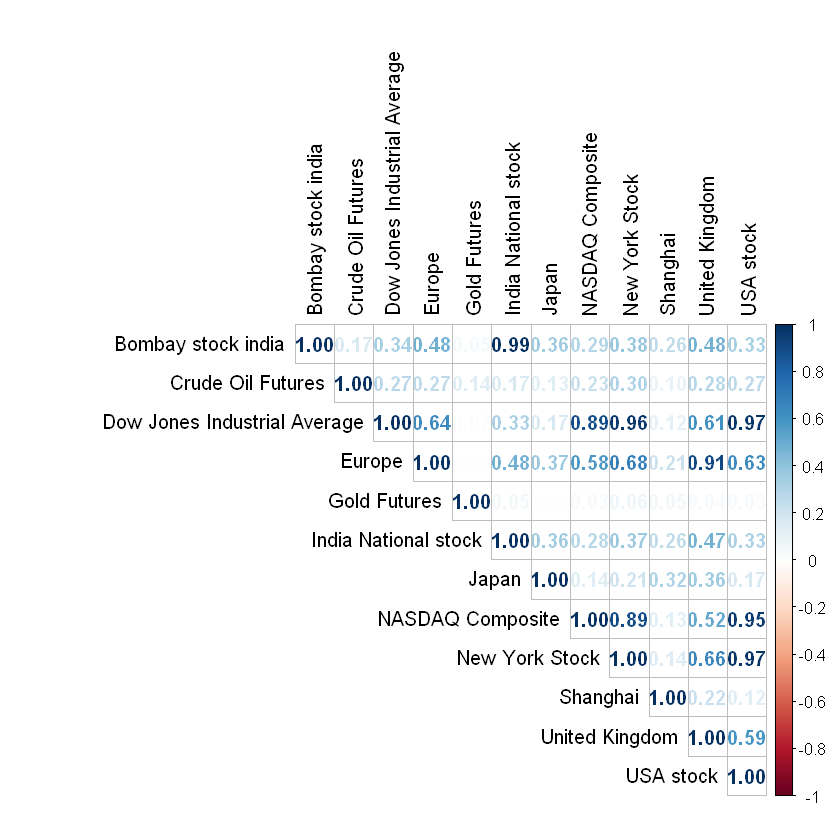

In [31]:
pivoted_data <- dcast(data, Date ~ Description, value.var = "Performance")
correlation_matrix <- cor(pivoted_data[, -1], use = "complete.obs")
corrplot(correlation_matrix, method = "number", type = "upper", tl.col = "black")

- Bombay Stock Exchange and National Stock Exchange of India : 0.99
- Dow Jones Industrial Average and New York Stock: 0.96
- Dow Jones Industrial Average and USA stock: 0.97
- NASDAQ Composite and New York Stock: 0.89
- NASDAQ Composite and USA Stock: 0.95
- New York Stock and USA stock: 0.97


To reduce redundancy, we should remove one market from each pair.In terms of maintaining a diverse representation, markets with a lower significance or relevance in your analysis will be removed.



In [32]:
markets_to_remove <- c("India National stock", "Dow Jones Industrial Average", "NASDAQ Composite","United Kingdom","New York Stock")
data <- data[!data$Description %in% markets_to_remove, ]

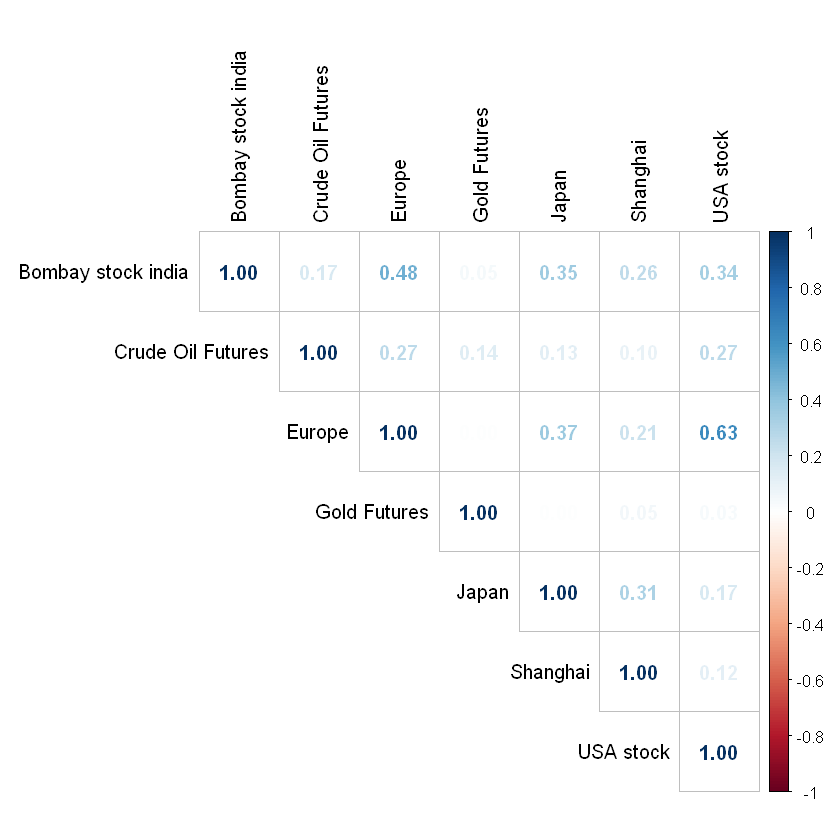

In [33]:
pivoted_data <- dcast(data, Date ~ Description, value.var = "Performance")
correlation_matrix <- cor(pivoted_data[, -1], use = "complete.obs")
corrplot(correlation_matrix, method = "number", type = "upper", tl.col = "black")

- Nifty 50:it had a very high correlation (0.99) with BSE SENSEX. Since both Nifty 50 and BSE SENSEX are major Indian stock market indices and represent a similar basket of stocks from the Indian market, they provide redundant information. Removing one of them can help reduce multicollinearity in your analysis.

- Dow Jones Industrial Average: This index was removed because it had strong correlations (0.89) with both NASDAQ Composite and NYSE Composite. Dow Jones Industrial Average, NASDAQ Composite, and NYSE Composite represent different aspects of the US stock market, but their strong correlations can lead to redundancy in your analysis.

- NASDAQ Composite: You removed NASDAQ Composite due to its high correlation (0.89) with both Dow Jones Industrial Average and NYSE Composite. NASDAQ Composite, Dow Jones Industrial Average, and NYSE Composite all provide insights into the US stock market, but their high correlations could introduce multicollinearity issues.

- FTSE 100: FTSE 100 was removed because of its strong correlation (0.91) with Euronext 100. Both indices cover European markets, and their high correlation might result in redundant information in your analysis.

- NYSE Composite: NYSE Composite was removed due to its high correlation (0.97) with S&P 500. Both indices represent the US stock market and have a very strong correlation, which could lead to multicollinearity problems in your analysis.

By removing these markets, we aim to reduce redundancy and multicollinearity in your analysis, which can provide more meaningful and accurate insights.

In [34]:
correlation_data <- data %>%
  group_by(Description) %>%
  summarise(Correlation = cor(Adj.Close, Performance, use = "complete.obs"))
print(correlation_data)

# A tibble: 7 x 2
  Description        Correlation
  <fct>                    <dbl>
1 Bombay stock india      0.0181
2 Crude Oil Futures       0.0664
3 Europe                  0.0296
4 Gold Futures            0.0221
5 Japan                   0.0251
6 Shanghai                0.0399
7 USA stock               0.0179


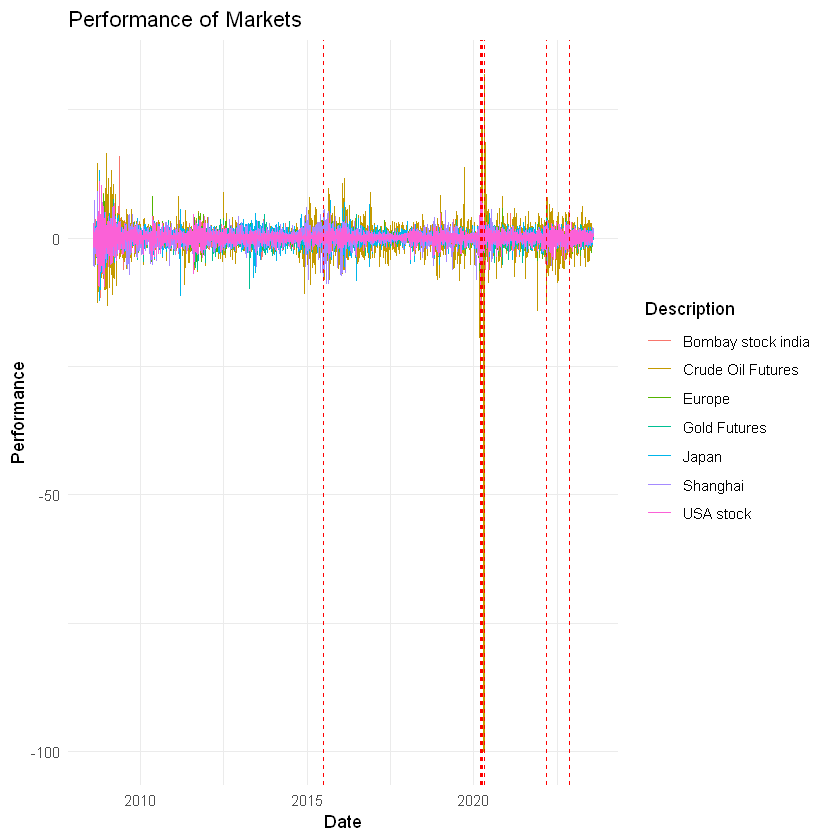

In [40]:
p <- ggplot(data, aes(x = Date, y = Performance, color = Description)) +
  geom_line() +
  labs(title = "Performance of Markets", x = "Date", y = "Performance") +
  theme_minimal() +
  theme(legend.position = "right") +
  
  geom_vline(xintercept = as.numeric(as.Date(c("2015-06-30", "2020-03-13", "2020-03-24", "2020-03-24", "2020-03-24",
                                               "2020-03-24", "2020-03-25", "2020-04-07", "2020-04-07",
                                               "2020-04-21", "2022-03-09", "2022-11-10"))),
             linetype = "dashed", color = "red")

print(p)

Overall, the low correlation values across all these markets indicate that changes in their daily adjusted closing prices do not strongly correlate with their daily performance. Other factors and variables are likely playing a more dominant role in influencing the daily performance of these markets.

In [41]:
data$Date <- as.Date(data$Date)
split_datasets <- data %>%
  group_split(Description)

Warning message:
"... is ignored in group_split(<grouped_df>), please use group_by(..., .add = TRUE) %>% group_split()"

In [42]:
India <- split_datasets[[1]]
Oil<- split_datasets[[2]]
Europe <- split_datasets[[3]]
Gold <- split_datasets[[4]]
Japan <- split_datasets[[5]]
USA <- split_datasets[[6]]
Shanghai <- split_datasets[[7]]

## Stationarity 

The Augmented Dickey-Fuller (ADF) test is used to determine whether a time series has a unit root (non-stationary) or not. The null hypothesis of the test is that the time series has a unit root, indicating that it is non-stationary, while the alternative hypothesis is that the time series is stationary.

The output is the result of performing the Augmented Dickey-Fuller (ADF) test on each subset of the global stock market dataset based on unique values of the 'Description' column. Each result section includes the test statistics, p-values, and critical values for different confidence levels.

In each result section, the key values to focus on are the test statistic and the p-value. The test statistic is compared to the critical values to determine whether the null hypothesis of a unit root (non-stationarity) can be rejected. If the p-value is less than the significance level 0.05,the null hypothesis will be rejected and conclude that the time series is stationary.


In [43]:
adf_results <- data %>%
  group_by(Description) %>%
  summarize(ADF_Result = adf.test(Performance)$p.value)

conclude_stationarity <- function(p_value, significance_level = 0.05) {
  if (p_value < significance_level) {
    return("Stationary")
  } else {
    return("Non-Stationary")
  }
}

adf_results <- adf_results %>%
  mutate(Stationarity = conclude_stationarity(ADF_Result))


adf_results

Warning message in adf.test(Performance):
"p-value smaller than printed p-value"Warning message in adf.test(Performance):
"p-value smaller than printed p-value"Warning message in adf.test(Performance):
"p-value smaller than printed p-value"Warning message in adf.test(Performance):
"p-value smaller than printed p-value"Warning message in adf.test(Performance):
"p-value smaller than printed p-value"Warning message in adf.test(Performance):
"p-value smaller than printed p-value"Warning message in adf.test(Performance):
"p-value smaller than printed p-value"Warning message in if (p_value < significance_level) {:
"the condition has length > 1 and only the first element will be used"

Description,ADF_Result,Stationarity
Bombay stock india,0.01,Stationary
Crude Oil Futures,0.01,Stationary
Europe,0.01,Stationary
Gold Futures,0.01,Stationary
Japan,0.01,Stationary
Shanghai,0.01,Stationary
USA stock,0.01,Stationary


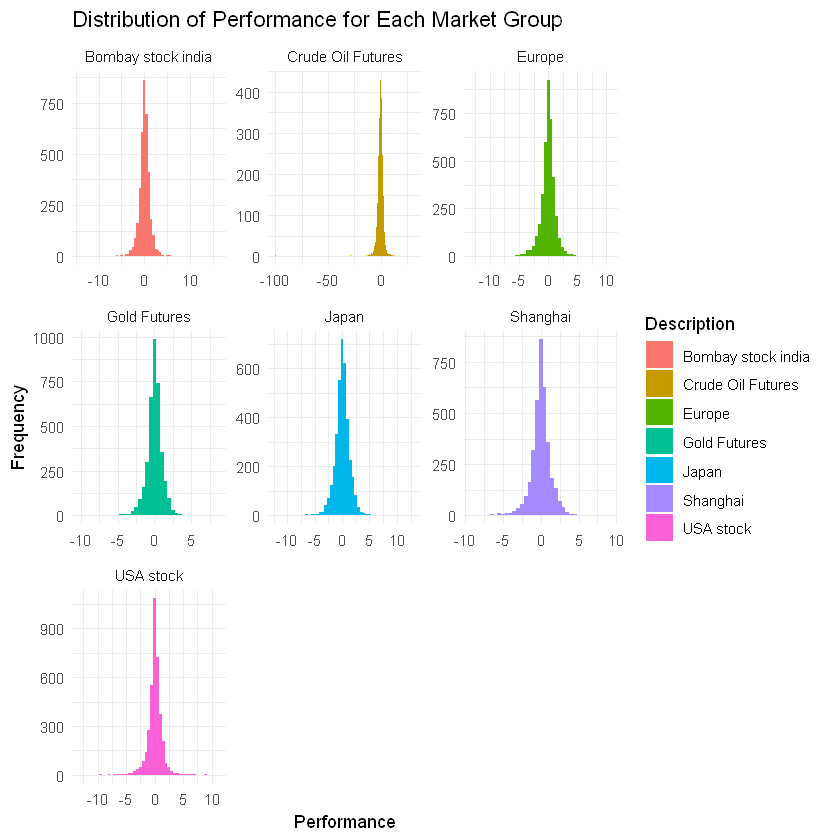

In [44]:
data %>%
  ggplot(aes(x = Performance, fill = Description)) +
  geom_histogram(binwidth = 0.5, position = "dodge") +
  facet_wrap(~ Description, scales = "free") +
  labs(title = "Distribution of Performance for Each Market Group",
       x = "Performance", y = "Frequency") +
  theme_minimal()

In [45]:
mean_performance <- data %>%
  group_by(Description) %>%
  summarise(Mean_Performance = format(round(mean(Performance), 1), nsmall = 1))
mean_performance

Description,Mean_Performance
Bombay stock india,0.0
Crude Oil Futures,0.0
Europe,0.0
Gold Futures,0.0
Japan,0.0
Shanghai,0.0
USA stock,0.0


The daily returns data actually exhibits mean-reversion behavior because it is stationary and has this property. The non-constant variance and the mean tend to be zero that characterize this type of series indicate a cycle of low volatility and high volatility.

One can see from the plot above that high returns spikes are followed by other high spikes, while low returns spikes are followed by other low spikes. These spikes signify volatility, and it appears that the proximity of low spikes and high spikes in the data suggests the presence of volatility clustering. This works well for predicting risk.


# Modelling Volatility: ARCH and GARCH Models

A statistical model known as the ARCH (Autoregressive Conditional Heteroskedasticity) model is used in economics to analyze time series data that show volatility clustering, which implies that periods of high volatility alternate with periods of low volatility. 

Heteroskedasticity, on the other hand, is a statistical concept that refers to the situation where the variance of the residuals (or errors) in a regression model is not constant across all levels of the independent variable(s). In other words, the spread or dispersion of the residuals changes as the values of the independent variables change. This violates one of the assumptions of ordinary least squares (OLS) regression, which assumes homoskedasticity (constant variance of residuals).

In [49]:
returns <- India$Performance
garch_spec <- ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(1, 0)))
garch_fit <- ugarchfit(spec = garch_spec, data = returns)
squared_residuals <- residuals(garch_fit)^2
n <- length(squared_residuals)
lm_statistic <- n * (sum(squared_residuals^2) / sum(squared_residuals)^2)
p_value <- 1 - pchisq(lm_statistic, df = 1)
cat("ARCH test results:\n\n")
cat("LM Statistic:", lm_statistic, "\n")
cat("p-value:", p_value, "\n")

ARCH test results:

LM Statistic: 1.515552 
p-value: 0.2182938 


In [63]:
returns <- Oil$Performance
garch_spec <- ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(1, 0)))
garch_fit <- ugarchfit(spec = garch_spec, data = returns)
squared_residuals <- residuals(garch_fit)^2
n <- length(squared_residuals)
lm_statistic <- n * (sum(squared_residuals^2) / sum(squared_residuals)^2)
p_value <- 1 - pchisq(lm_statistic, df = 1)
cat("ARCH test results:\n\n")
cat("LM Statistic:", lm_statistic, "\n")
cat("p-value:", p_value, "\n")

ARCH test results:

LM Statistic: 306.6523 
p-value: 0 


In [64]:
returns <- Europe$Performance
garch_spec <- ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(1, 0)))
garch_fit <- ugarchfit(spec = garch_spec, data = returns)
squared_residuals <- residuals(garch_fit)^2
n <- length(squared_residuals)
lm_statistic <- n * (sum(squared_residuals^2) / sum(squared_residuals)^2)
p_value <- 1 - pchisq(lm_statistic, df = 1)
cat("ARCH test results:\n\n")
cat("LM Statistic:", lm_statistic, "\n")
cat("p-value:", p_value, "\n")

ARCH test results:

LM Statistic: 11.96605 
p-value: 0.0005417873 


In [65]:
returns <- Gold$Performance
garch_spec <- ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(1, 0)))
garch_fit <- ugarchfit(spec = garch_spec, data = returns)
squared_residuals <- residuals(garch_fit)^2
n <- length(squared_residuals)
lm_statistic <- n * (sum(squared_residuals^2) / sum(squared_residuals)^2)
p_value <- 1 - pchisq(lm_statistic, df = 1)
cat("ARCH test results:\n\n")
cat("LM Statistic:", lm_statistic, "\n")
cat("p-value:", p_value, "\n")

ARCH test results:

LM Statistic: 9.147258 
p-value: 0.00249091 


In [68]:
returns <-Japan$Performance
garch_spec <- ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(1, 0)))
garch_fit <- ugarchfit(spec = garch_spec, data = returns)
squared_residuals <- residuals(garch_fit)^2
n <- length(squared_residuals)
lm_statistic <- n * (sum(squared_residuals^2) / sum(squared_residuals)^2)
p_value <- 1 - pchisq(lm_statistic, df = 1)
cat("ARCH test results:\n\n")
cat("LM Statistic:", lm_statistic, "\n")
cat("p-value:", p_value, "\n")

ARCH test results:

LM Statistic: 11.40687 
p-value: 0.0007317318 


In [69]:
returns <- USA$Performance
garch_spec <- ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(1, 0)))
garch_fit <- ugarchfit(spec = garch_spec, data = returns)
squared_residuals <- residuals(garch_fit)^2
n <- length(squared_residuals)
lm_statistic <- n * (sum(squared_residuals^2) / sum(squared_residuals)^2)
p_value <- 1 - pchisq(lm_statistic, df = 1)
cat("ARCH test results:\n\n")
cat("LM Statistic:", lm_statistic, "\n")
cat("p-value:", p_value, "\n")

ARCH test results:

LM Statistic: 8.553412 
p-value: 0.003448752 


In [72]:
returns <- Shanghai$Performance
garch_spec <- ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(1, 0)))
garch_fit <- ugarchfit(spec = garch_spec, data = returns)
squared_residuals <- residuals(garch_fit)^2
n <- length(squared_residuals)
lm_statistic <- n * (sum(squared_residuals^2) / sum(squared_residuals)^2)
p_value <- 1 - pchisq(lm_statistic, df = 1)
cat("ARCH test results:\n\n")
cat("LM Statistic:", lm_statistic, "\n")
cat("p-value:", p_value, "\n")

ARCH test results:

LM Statistic: 14.02761 
p-value: 0.0001801461 


For each market, you have the following information:

<b>LM Statistic:</b> This is the value of the LM (Lagrange Multiplier) statistic, which is a test statistic used to assess the presence of ARCH effects. The LM statistic is calculated based on the squared residuals or squared returns from the model. A larger LM statistic indicates stronger evidence of ARCH effects.

<b>p-value:</b> This is the p-value associated with the LM statistic. The p-value indicates the probability of observing a LM statistic as extreme as the one calculated if the null hypothesis is true. In the context of ARCH testing, the null hypothesis is that there are no ARCH effects (i.e., no conditional heteroskedasticity). A low p-value (below 0.05) suggests that you have evidence to reject the null hypothesis and conclude that there are ARCH effects present.

- All p-values are in a scientific notation and represent very small numbers that are below the 0.05 threshold, which suggests that there is an ARCH effect to the data, and we can use these models to forecast volatility.

## GARCH Models

<b>Grid search </b>is a technique used to systematically search through a predefined set of hyperparameters to find the combination that results in the best performance according to a specified criterion. In the context of time series modeling and GARCH models, grid search is used to find the optimal combination of AR(p) and MA(q) orders that minimizes a chosen criterion.

In [48]:
dataset_list <- list(India,Europe, Gold ,Japan ,USA, Shanghai )

p_values <- c(1, 2,3,4)       
q_values <- c( 0,1, 2,3,4)    

fit_best_garch <- function(returns) {
  best_model <- NULL
  best_params <- NULL
  best_aic <- Inf
  
  for (p in p_values) {
    for (q in q_values) {
      formula <- as.formula(paste("returns ~ garch(", p, ",", q, ")"))
      model <- garchFit(formula = formula, data = returns)
      
      n_params <- length(coef(model))
      neg_log_likelihood <- -model@fit$llh
      aic <- 2 * n_params + 2 * neg_log_likelihood
      
      if (aic < best_aic) {
        best_aic <- aic
        best_model <- model
        best_params <- c(p, q)
      }
    }
  }
  
  return(best_model)
}

best_models <- list()
for (i in seq_along(dataset_list)) {
  dataset <- dataset_list[[i]]
  returns <- dataset$Performance
  best_models[[i]] <- fit_best_garch(returns)
}
for (i in seq_along(dataset_list)) {
  dataset_name <- names(dataset_list)[i]
  cat("\nDataset: ", dataset_name, "\n")
  print(summary(best_models[[i]]))
}



Series Initialization:
 ARMA Model:                arma
 Formula Mean:              ~ arma(0, 0)
 GARCH Model:               garch
 Formula Variance:          ~ garch(1, 0)
 ARMA Order:                0 0
 Max ARMA Order:            0
 GARCH Order:               1 0
 Max GARCH Order:           1
 Maximum Order:             1
 Conditional Dist:          norm
 h.start:                   2
 llh.start:                 1
 Length of Series:          3675
 Recursion Init:            mci
 Series Scale:              1.298171

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U           V     params includes
    mu     -0.31591949   0.3159195 0.03159195     TRUE
    omega   0.00000100 100.0000000 0.10000000     TRUE
    alpha1  0.00000001   1.0000000 0.10000000     TRUE
    gamma1 -0.99999999   1.0000000 0.10000000    FALSE
    delta   0.00000000   2.0000000 2.0000

Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


Time to Estimate Parameters:
 Time difference of 1.838249 secs

Series Initialization:
 ARMA Model:                arma
 Formula Mean:              ~ arma(0, 0)
 GARCH Model:               garch
 Formula Variance:          ~ garch(3, 4)
 ARMA Order:                0 0
 Max ARMA Order:            0
 GARCH Order:               3 4
 Max GARCH Order:           4
 Maximum Order:             4
 Conditional Dist:          norm
 h.start:                   5
 llh.start:                 1
 Length of Series:          3675
 Recursion Init:            mci
 Series Scale:              1.298171

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U           V     params includes
    mu     -0.31591949   0.3159195 0.03159195     TRUE
    omega   0.00000100 100.0000000 0.10000000     TRUE
    alpha1  0.00000001   1.0000000 0.03333333     TRUE
    alpha2  0.00000001   1.00000

Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


Time to Estimate Parameters:
 Time difference of 2.82794 secs

Series Initialization:
 ARMA Model:                arma
 Formula Mean:              ~ arma(0, 0)
 GARCH Model:               garch
 Formula Variance:          ~ garch(4, 0)
 ARMA Order:                0 0
 Max ARMA Order:            0
 GARCH Order:               4 0
 Max GARCH Order:           4
 Maximum Order:             4
 Conditional Dist:          norm
 h.start:                   5
 llh.start:                 1
 Length of Series:          3675
 Recursion Init:            mci
 Series Scale:              1.298171

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U           V     params includes
    mu     -0.31591949   0.3159195 0.03159195     TRUE
    omega   0.00000100 100.0000000 0.10000000     TRUE
    alpha1  0.00000001   1.0000000 0.02500000     TRUE
    alpha2  0.00000001   1.000000

Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


Time to Estimate Parameters:
 Time difference of 2.227104 secs

Series Initialization:
 ARMA Model:                arma
 Formula Mean:              ~ arma(0, 0)
 GARCH Model:               garch
 Formula Variance:          ~ garch(4, 4)
 ARMA Order:                0 0
 Max ARMA Order:            0
 GARCH Order:               4 4
 Max GARCH Order:           4
 Maximum Order:             4
 Conditional Dist:          norm
 h.start:                   5
 llh.start:                 1
 Length of Series:          3675
 Recursion Init:            mci
 Series Scale:              1.298171

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U           V     params includes
    mu     -0.31591949   0.3159195 0.03159195     TRUE
    omega   0.00000100 100.0000000 0.10000000     TRUE
    alpha1  0.00000001   1.0000000 0.02500000     TRUE
    alpha2  0.00000001   1.00000

Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


Time to Estimate Parameters:
 Time difference of 0.929466 secs

Series Initialization:
 ARMA Model:                arma
 Formula Mean:              ~ arma(0, 0)
 GARCH Model:               garch
 Formula Variance:          ~ garch(1, 4)
 ARMA Order:                0 0
 Max ARMA Order:            0
 GARCH Order:               1 4
 Max GARCH Order:           4
 Maximum Order:             4
 Conditional Dist:          norm
 h.start:                   5
 llh.start:                 1
 Length of Series:          3834
 Recursion Init:            mci
 Series Scale:              1.300197

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U           V     params includes
    mu     -0.12606146   0.1260615 0.01260615     TRUE
    omega   0.00000100 100.0000000 0.10000000     TRUE
    alpha1  0.00000001   1.0000000 0.10000000     TRUE
    gamma1 -0.99999999   1.00000

Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


Time to Estimate Parameters:
 Time difference of 1.537417 secs

Series Initialization:
 ARMA Model:                arma
 Formula Mean:              ~ arma(0, 0)
 GARCH Model:               garch
 Formula Variance:          ~ garch(2, 0)
 ARMA Order:                0 0
 Max ARMA Order:            0
 GARCH Order:               2 0
 Max GARCH Order:           2
 Maximum Order:             2
 Conditional Dist:          norm
 h.start:                   3
 llh.start:                 1
 Length of Series:          3834
 Recursion Init:            mci
 Series Scale:              1.300197

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U           V     params includes
    mu     -0.12606146   0.1260615 0.01260615     TRUE
    omega   0.00000100 100.0000000 0.10000000     TRUE
    alpha1  0.00000001   1.0000000 0.05000000     TRUE
    alpha2  0.00000001   1.00000

Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


Time to Estimate Parameters:
 Time difference of 1.862525 secs

Series Initialization:
 ARMA Model:                arma
 Formula Mean:              ~ arma(0, 0)
 GARCH Model:               garch
 Formula Variance:          ~ garch(2, 4)
 ARMA Order:                0 0
 Max ARMA Order:            0
 GARCH Order:               2 4
 Max GARCH Order:           4
 Maximum Order:             4
 Conditional Dist:          norm
 h.start:                   5
 llh.start:                 1
 Length of Series:          3834
 Recursion Init:            mci
 Series Scale:              1.300197

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U           V     params includes
    mu     -0.12606146   0.1260615 0.01260615     TRUE
    omega   0.00000100 100.0000000 0.10000000     TRUE
    alpha1  0.00000001   1.0000000 0.05000000     TRUE
    alpha2  0.00000001   1.00000

Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


Time to Estimate Parameters:
 Time difference of 2.244901 secs

Series Initialization:
 ARMA Model:                arma
 Formula Mean:              ~ arma(0, 0)
 GARCH Model:               garch
 Formula Variance:          ~ garch(3, 0)
 ARMA Order:                0 0
 Max ARMA Order:            0
 GARCH Order:               3 0
 Max GARCH Order:           3
 Maximum Order:             3
 Conditional Dist:          norm
 h.start:                   4
 llh.start:                 1
 Length of Series:          3834
 Recursion Init:            mci
 Series Scale:              1.300197

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U           V     params includes
    mu     -0.12606146   0.1260615 0.01260615     TRUE
    omega   0.00000100 100.0000000 0.10000000     TRUE
    alpha1  0.00000001   1.0000000 0.03333333     TRUE
    alpha2  0.00000001   1.00000

Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


Time to Estimate Parameters:
 Time difference of 1.782936 secs

Series Initialization:
 ARMA Model:                arma
 Formula Mean:              ~ arma(0, 0)
 GARCH Model:               garch
 Formula Variance:          ~ garch(3, 4)
 ARMA Order:                0 0
 Max ARMA Order:            0
 GARCH Order:               3 4
 Max GARCH Order:           4
 Maximum Order:             4
 Conditional Dist:          norm
 h.start:                   5
 llh.start:                 1
 Length of Series:          3834
 Recursion Init:            mci
 Series Scale:              1.300197

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U           V     params includes
    mu     -0.12606146   0.1260615 0.01260615     TRUE
    omega   0.00000100 100.0000000 0.10000000     TRUE
    alpha1  0.00000001   1.0000000 0.03333333     TRUE
    alpha2  0.00000001   1.00000

Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


Time to Estimate Parameters:
 Time difference of 2.276875 secs

Series Initialization:
 ARMA Model:                arma
 Formula Mean:              ~ arma(0, 0)
 GARCH Model:               garch
 Formula Variance:          ~ garch(4, 0)
 ARMA Order:                0 0
 Max ARMA Order:            0
 GARCH Order:               4 0
 Max GARCH Order:           4
 Maximum Order:             4
 Conditional Dist:          norm
 h.start:                   5
 llh.start:                 1
 Length of Series:          3834
 Recursion Init:            mci
 Series Scale:              1.300197

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U           V     params includes
    mu     -0.12606146   0.1260615 0.01260615     TRUE
    omega   0.00000100 100.0000000 0.10000000     TRUE
    alpha1  0.00000001   1.0000000 0.02500000     TRUE
    alpha2  0.00000001   1.00000

Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


Time to Estimate Parameters:
 Time difference of 2.128308 secs

Series Initialization:
 ARMA Model:                arma
 Formula Mean:              ~ arma(0, 0)
 GARCH Model:               garch
 Formula Variance:          ~ garch(4, 3)
 ARMA Order:                0 0
 Max ARMA Order:            0
 GARCH Order:               4 3
 Max GARCH Order:           4
 Maximum Order:             4
 Conditional Dist:          norm
 h.start:                   5
 llh.start:                 1
 Length of Series:          3834
 Recursion Init:            mci
 Series Scale:              1.300197

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U           V     params includes
    mu     -0.12606146   0.1260615 0.01260615     TRUE
    omega   0.00000100 100.0000000 0.10000000     TRUE
    alpha1  0.00000001   1.0000000 0.02500000     TRUE
    alpha2  0.00000001   1.00000

Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


Time to Estimate Parameters:
 Time difference of 2.612816 secs

Series Initialization:
 ARMA Model:                arma
 Formula Mean:              ~ arma(0, 0)
 GARCH Model:               garch
 Formula Variance:          ~ garch(4, 4)
 ARMA Order:                0 0
 Max ARMA Order:            0
 GARCH Order:               4 4
 Max GARCH Order:           4
 Maximum Order:             4
 Conditional Dist:          norm
 h.start:                   5
 llh.start:                 1
 Length of Series:          3834
 Recursion Init:            mci
 Series Scale:              1.300197

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U           V     params includes
    mu     -0.12606146   0.1260615 0.01260615     TRUE
    omega   0.00000100 100.0000000 0.10000000     TRUE
    alpha1  0.00000001   1.0000000 0.02500000     TRUE
    alpha2  0.00000001   1.00000

Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


Time to Estimate Parameters:
 Time difference of 3.093692 secs

Series Initialization:
 ARMA Model:                arma
 Formula Mean:              ~ arma(0, 0)
 GARCH Model:               garch
 Formula Variance:          ~ garch(1, 0)
 ARMA Order:                0 0
 Max ARMA Order:            0
 GARCH Order:               1 0
 Max GARCH Order:           1
 Maximum Order:             1
 Conditional Dist:          norm
 h.start:                   2
 llh.start:                 1
 Length of Series:          3768
 Recursion Init:            mci
 Series Scale:              1.110703

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U           V     params includes
    mu     -0.18364044   0.1836404 0.01836404     TRUE
    omega   0.00000100 100.0000000 0.10000000     TRUE
    alpha1  0.00000001   1.0000000 0.10000000     TRUE
    gamma1 -0.99999999   1.00000

Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


Time to Estimate Parameters:
 Time difference of 1.615238 secs

Series Initialization:
 ARMA Model:                arma
 Formula Mean:              ~ arma(0, 0)
 GARCH Model:               garch
 Formula Variance:          ~ garch(3, 0)
 ARMA Order:                0 0
 Max ARMA Order:            0
 GARCH Order:               3 0
 Max GARCH Order:           3
 Maximum Order:             3
 Conditional Dist:          norm
 h.start:                   4
 llh.start:                 1
 Length of Series:          3768
 Recursion Init:            mci
 Series Scale:              1.110703

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U           V     params includes
    mu     -0.18364044   0.1836404 0.01836404     TRUE
    omega   0.00000100 100.0000000 0.10000000     TRUE
    alpha1  0.00000001   1.0000000 0.03333333     TRUE
    alpha2  0.00000001   1.00000

Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


Time to Estimate Parameters:
 Time difference of 1.808551 secs

Series Initialization:
 ARMA Model:                arma
 Formula Mean:              ~ arma(0, 0)
 GARCH Model:               garch
 Formula Variance:          ~ garch(3, 3)
 ARMA Order:                0 0
 Max ARMA Order:            0
 GARCH Order:               3 3
 Max GARCH Order:           3
 Maximum Order:             3
 Conditional Dist:          norm
 h.start:                   4
 llh.start:                 1
 Length of Series:          3768
 Recursion Init:            mci
 Series Scale:              1.110703

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U           V     params includes
    mu     -0.18364044   0.1836404 0.01836404     TRUE
    omega   0.00000100 100.0000000 0.10000000     TRUE
    alpha1  0.00000001   1.0000000 0.03333333     TRUE
    alpha2  0.00000001   1.00000

Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


Time to Estimate Parameters:
 Time difference of 1.923213 secs

Series Initialization:
 ARMA Model:                arma
 Formula Mean:              ~ arma(0, 0)
 GARCH Model:               garch
 Formula Variance:          ~ garch(3, 4)
 ARMA Order:                0 0
 Max ARMA Order:            0
 GARCH Order:               3 4
 Max GARCH Order:           4
 Maximum Order:             4
 Conditional Dist:          norm
 h.start:                   5
 llh.start:                 1
 Length of Series:          3768
 Recursion Init:            mci
 Series Scale:              1.110703

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U           V     params includes
    mu     -0.18364044   0.1836404 0.01836404     TRUE
    omega   0.00000100 100.0000000 0.10000000     TRUE
    alpha1  0.00000001   1.0000000 0.03333333     TRUE
    alpha2  0.00000001   1.00000

Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


Time to Estimate Parameters:
 Time difference of 2.485596 secs

Series Initialization:
 ARMA Model:                arma
 Formula Mean:              ~ arma(0, 0)
 GARCH Model:               garch
 Formula Variance:          ~ garch(4, 0)
 ARMA Order:                0 0
 Max ARMA Order:            0
 GARCH Order:               4 0
 Max GARCH Order:           4
 Maximum Order:             4
 Conditional Dist:          norm
 h.start:                   5
 llh.start:                 1
 Length of Series:          3768
 Recursion Init:            mci
 Series Scale:              1.110703

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U           V     params includes
    mu     -0.18364044   0.1836404 0.01836404     TRUE
    omega   0.00000100 100.0000000 0.10000000     TRUE
    alpha1  0.00000001   1.0000000 0.02500000     TRUE
    alpha2  0.00000001   1.00000

Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


Time to Estimate Parameters:
 Time difference of 2.100441 secs

Series Initialization:
 ARMA Model:                arma
 Formula Mean:              ~ arma(0, 0)
 GARCH Model:               garch
 Formula Variance:          ~ garch(4, 3)
 ARMA Order:                0 0
 Max ARMA Order:            0
 GARCH Order:               4 3
 Max GARCH Order:           4
 Maximum Order:             4
 Conditional Dist:          norm
 h.start:                   5
 llh.start:                 1
 Length of Series:          3768
 Recursion Init:            mci
 Series Scale:              1.110703

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U           V     params includes
    mu     -0.18364044   0.1836404 0.01836404     TRUE
    omega   0.00000100 100.0000000 0.10000000     TRUE
    alpha1  0.00000001   1.0000000 0.02500000     TRUE
    alpha2  0.00000001   1.00000

Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


Time to Estimate Parameters:
 Time difference of 2.41144 secs

Series Initialization:
 ARMA Model:                arma
 Formula Mean:              ~ arma(0, 0)
 GARCH Model:               garch
 Formula Variance:          ~ garch(4, 4)
 ARMA Order:                0 0
 Max ARMA Order:            0
 GARCH Order:               4 4
 Max GARCH Order:           4
 Maximum Order:             4
 Conditional Dist:          norm
 h.start:                   5
 llh.start:                 1
 Length of Series:          3768
 Recursion Init:            mci
 Series Scale:              1.110703

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U           V     params includes
    mu     -0.18364044   0.1836404 0.01836404     TRUE
    omega   0.00000100 100.0000000 0.10000000     TRUE
    alpha1  0.00000001   1.0000000 0.02500000     TRUE
    alpha2  0.00000001   1.000000

Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


Time to Estimate Parameters:
 Time difference of 4.614989 secs

Series Initialization:
 ARMA Model:                arma
 Formula Mean:              ~ arma(0, 0)
 GARCH Model:               garch
 Formula Variance:          ~ garch(1, 0)
 ARMA Order:                0 0
 Max ARMA Order:            0
 GARCH Order:               1 0
 Max GARCH Order:           1
 Maximum Order:             1
 Conditional Dist:          norm
 h.start:                   2
 llh.start:                 1
 Length of Series:          3663
 Recursion Init:            mci
 Series Scale:              1.480893

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U           V     params includes
    mu     -0.16904486   0.1690449 0.01690449     TRUE
    omega   0.00000100 100.0000000 0.10000000     TRUE
    alpha1  0.00000001   1.0000000 0.10000000     TRUE
    gamma1 -0.99999999   1.00000

Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


Time to Estimate Parameters:
 Time difference of 1.468256 secs

Series Initialization:
 ARMA Model:                arma
 Formula Mean:              ~ arma(0, 0)
 GARCH Model:               garch
 Formula Variance:          ~ garch(2, 4)
 ARMA Order:                0 0
 Max ARMA Order:            0
 GARCH Order:               2 4
 Max GARCH Order:           4
 Maximum Order:             4
 Conditional Dist:          norm
 h.start:                   5
 llh.start:                 1
 Length of Series:          3663
 Recursion Init:            mci
 Series Scale:              1.480893

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U           V     params includes
    mu     -0.16904486   0.1690449 0.01690449     TRUE
    omega   0.00000100 100.0000000 0.10000000     TRUE
    alpha1  0.00000001   1.0000000 0.05000000     TRUE
    alpha2  0.00000001   1.00000

Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


Time to Estimate Parameters:
 Time difference of 1.422945 secs

Series Initialization:
 ARMA Model:                arma
 Formula Mean:              ~ arma(0, 0)
 GARCH Model:               garch
 Formula Variance:          ~ garch(3, 0)
 ARMA Order:                0 0
 Max ARMA Order:            0
 GARCH Order:               3 0
 Max GARCH Order:           3
 Maximum Order:             3
 Conditional Dist:          norm
 h.start:                   4
 llh.start:                 1
 Length of Series:          3663
 Recursion Init:            mci
 Series Scale:              1.480893

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U           V     params includes
    mu     -0.16904486   0.1690449 0.01690449     TRUE
    omega   0.00000100 100.0000000 0.10000000     TRUE
    alpha1  0.00000001   1.0000000 0.03333333     TRUE
    alpha2  0.00000001   1.00000

Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


Time to Estimate Parameters:
 Time difference of 1.737366 secs

Series Initialization:
 ARMA Model:                arma
 Formula Mean:              ~ arma(0, 0)
 GARCH Model:               garch
 Formula Variance:          ~ garch(3, 4)
 ARMA Order:                0 0
 Max ARMA Order:            0
 GARCH Order:               3 4
 Max GARCH Order:           4
 Maximum Order:             4
 Conditional Dist:          norm
 h.start:                   5
 llh.start:                 1
 Length of Series:          3663
 Recursion Init:            mci
 Series Scale:              1.480893

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U           V     params includes
    mu     -0.16904486   0.1690449 0.01690449     TRUE
    omega   0.00000100 100.0000000 0.10000000     TRUE
    alpha1  0.00000001   1.0000000 0.03333333     TRUE
    alpha2  0.00000001   1.00000

Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


Time to Estimate Parameters:
 Time difference of 2.641944 secs

Series Initialization:
 ARMA Model:                arma
 Formula Mean:              ~ arma(0, 0)
 GARCH Model:               garch
 Formula Variance:          ~ garch(4, 0)
 ARMA Order:                0 0
 Max ARMA Order:            0
 GARCH Order:               4 0
 Max GARCH Order:           4
 Maximum Order:             4
 Conditional Dist:          norm
 h.start:                   5
 llh.start:                 1
 Length of Series:          3663
 Recursion Init:            mci
 Series Scale:              1.480893

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U           V     params includes
    mu     -0.16904486   0.1690449 0.01690449     TRUE
    omega   0.00000100 100.0000000 0.10000000     TRUE
    alpha1  0.00000001   1.0000000 0.02500000     TRUE
    alpha2  0.00000001   1.00000

Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


Time to Estimate Parameters:
 Time difference of 2.282292 secs

Series Initialization:
 ARMA Model:                arma
 Formula Mean:              ~ arma(0, 0)
 GARCH Model:               garch
 Formula Variance:          ~ garch(4, 4)
 ARMA Order:                0 0
 Max ARMA Order:            0
 GARCH Order:               4 4
 Max GARCH Order:           4
 Maximum Order:             4
 Conditional Dist:          norm
 h.start:                   5
 llh.start:                 1
 Length of Series:          3663
 Recursion Init:            mci
 Series Scale:              1.480893

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U           V     params includes
    mu     -0.16904486   0.1690449 0.01690449     TRUE
    omega   0.00000100 100.0000000 0.10000000     TRUE
    alpha1  0.00000001   1.0000000 0.02500000     TRUE
    alpha2  0.00000001   1.00000

Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


Time to Estimate Parameters:
 Time difference of 2.656108 secs

Series Initialization:
 ARMA Model:                arma
 Formula Mean:              ~ arma(0, 0)
 GARCH Model:               garch
 Formula Variance:          ~ garch(1, 0)
 ARMA Order:                0 0
 Max ARMA Order:            0
 GARCH Order:               1 0
 Max GARCH Order:           1
 Maximum Order:             1
 Conditional Dist:          norm
 h.start:                   2
 llh.start:                 1
 Length of Series:          3639
 Recursion Init:            mci
 Series Scale:              1.416242

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V    params includes
    mu     -0.03033400   0.030334 0.0030334     TRUE
    omega   0.00000100 100.000000 0.1000000     TRUE
    alpha1  0.00000001   1.000000 0.1000000     TRUE
    gamma1 -0.99999999   1.000000 0.1000

Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


Time to Estimate Parameters:
 Time difference of 0.9574418 secs

Series Initialization:
 ARMA Model:                arma
 Formula Mean:              ~ arma(0, 0)
 GARCH Model:               garch
 Formula Variance:          ~ garch(1, 4)
 ARMA Order:                0 0
 Max ARMA Order:            0
 GARCH Order:               1 4
 Max GARCH Order:           4
 Maximum Order:             4
 Conditional Dist:          norm
 h.start:                   5
 llh.start:                 1
 Length of Series:          3639
 Recursion Init:            mci
 Series Scale:              1.416242

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V    params includes
    mu     -0.03033400   0.030334 0.0030334     TRUE
    omega   0.00000100 100.000000 0.1000000     TRUE
    alpha1  0.00000001   1.000000 0.1000000     TRUE
    gamma1 -0.99999999   1.000000 0.100

Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


Time to Estimate Parameters:
 Time difference of 1.357052 secs

Series Initialization:
 ARMA Model:                arma
 Formula Mean:              ~ arma(0, 0)
 GARCH Model:               garch
 Formula Variance:          ~ garch(2, 3)
 ARMA Order:                0 0
 Max ARMA Order:            0
 GARCH Order:               2 3
 Max GARCH Order:           3
 Maximum Order:             3
 Conditional Dist:          norm
 h.start:                   4
 llh.start:                 1
 Length of Series:          3639
 Recursion Init:            mci
 Series Scale:              1.416242

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V    params includes
    mu     -0.03033400   0.030334 0.0030334     TRUE
    omega   0.00000100 100.000000 0.1000000     TRUE
    alpha1  0.00000001   1.000000 0.0500000     TRUE
    alpha2  0.00000001   1.000000 0.0500

Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


Time to Estimate Parameters:
 Time difference of 2.454537 secs

Series Initialization:
 ARMA Model:                arma
 Formula Mean:              ~ arma(0, 0)
 GARCH Model:               garch
 Formula Variance:          ~ garch(2, 4)
 ARMA Order:                0 0
 Max ARMA Order:            0
 GARCH Order:               2 4
 Max GARCH Order:           4
 Maximum Order:             4
 Conditional Dist:          norm
 h.start:                   5
 llh.start:                 1
 Length of Series:          3639
 Recursion Init:            mci
 Series Scale:              1.416242

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V    params includes
    mu     -0.03033400   0.030334 0.0030334     TRUE
    omega   0.00000100 100.000000 0.1000000     TRUE
    alpha1  0.00000001   1.000000 0.0500000     TRUE
    alpha2  0.00000001   1.000000 0.0500

Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


Time to Estimate Parameters:
 Time difference of 1.581647 secs

Series Initialization:
 ARMA Model:                arma
 Formula Mean:              ~ arma(0, 0)
 GARCH Model:               garch
 Formula Variance:          ~ garch(3, 0)
 ARMA Order:                0 0
 Max ARMA Order:            0
 GARCH Order:               3 0
 Max GARCH Order:           3
 Maximum Order:             3
 Conditional Dist:          norm
 h.start:                   4
 llh.start:                 1
 Length of Series:          3639
 Recursion Init:            mci
 Series Scale:              1.416242

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V     params includes
    mu     -0.03033400   0.030334 0.00303340     TRUE
    omega   0.00000100 100.000000 0.10000000     TRUE
    alpha1  0.00000001   1.000000 0.03333333     TRUE
    alpha2  0.00000001   1.000000 0.

Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


Time to Estimate Parameters:
 Time difference of 1.590508 secs

Series Initialization:
 ARMA Model:                arma
 Formula Mean:              ~ arma(0, 0)
 GARCH Model:               garch
 Formula Variance:          ~ garch(3, 3)
 ARMA Order:                0 0
 Max ARMA Order:            0
 GARCH Order:               3 3
 Max GARCH Order:           3
 Maximum Order:             3
 Conditional Dist:          norm
 h.start:                   4
 llh.start:                 1
 Length of Series:          3639
 Recursion Init:            mci
 Series Scale:              1.416242

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V     params includes
    mu     -0.03033400   0.030334 0.00303340     TRUE
    omega   0.00000100 100.000000 0.10000000     TRUE
    alpha1  0.00000001   1.000000 0.03333333     TRUE
    alpha2  0.00000001   1.000000 0.

Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


Time to Estimate Parameters:
 Time difference of 2.341214 secs

Series Initialization:
 ARMA Model:                arma
 Formula Mean:              ~ arma(0, 0)
 GARCH Model:               garch
 Formula Variance:          ~ garch(3, 4)
 ARMA Order:                0 0
 Max ARMA Order:            0
 GARCH Order:               3 4
 Max GARCH Order:           4
 Maximum Order:             4
 Conditional Dist:          norm
 h.start:                   5
 llh.start:                 1
 Length of Series:          3639
 Recursion Init:            mci
 Series Scale:              1.416242

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V     params includes
    mu     -0.03033400   0.030334 0.00303340     TRUE
    omega   0.00000100 100.000000 0.10000000     TRUE
    alpha1  0.00000001   1.000000 0.03333333     TRUE
    alpha2  0.00000001   1.000000 0.

Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


Time to Estimate Parameters:
 Time difference of 2.001096 secs

Series Initialization:
 ARMA Model:                arma
 Formula Mean:              ~ arma(0, 0)
 GARCH Model:               garch
 Formula Variance:          ~ garch(4, 3)
 ARMA Order:                0 0
 Max ARMA Order:            0
 GARCH Order:               4 3
 Max GARCH Order:           4
 Maximum Order:             4
 Conditional Dist:          norm
 h.start:                   5
 llh.start:                 1
 Length of Series:          3639
 Recursion Init:            mci
 Series Scale:              1.416242

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V    params includes
    mu     -0.03033400   0.030334 0.0030334     TRUE
    omega   0.00000100 100.000000 0.1000000     TRUE
    alpha1  0.00000001   1.000000 0.0250000     TRUE
    alpha2  0.00000001   1.000000 0.0250

Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


Time to Estimate Parameters:
 Time difference of 2.737388 secs

Series Initialization:
 ARMA Model:                arma
 Formula Mean:              ~ arma(0, 0)
 GARCH Model:               garch
 Formula Variance:          ~ garch(4, 4)
 ARMA Order:                0 0
 Max ARMA Order:            0
 GARCH Order:               4 4
 Max GARCH Order:           4
 Maximum Order:             4
 Conditional Dist:          norm
 h.start:                   5
 llh.start:                 1
 Length of Series:          3639
 Recursion Init:            mci
 Series Scale:              1.416242

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V    params includes
    mu     -0.03033400   0.030334 0.0030334     TRUE
    omega   0.00000100 100.000000 0.1000000     TRUE
    alpha1  0.00000001   1.000000 0.0250000     TRUE
    alpha2  0.00000001   1.000000 0.0250

Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


Time to Estimate Parameters:
 Time difference of 2.576957 secs

Series Initialization:
 ARMA Model:                arma
 Formula Mean:              ~ arma(0, 0)
 GARCH Model:               garch
 Formula Variance:          ~ garch(4, 0)
 ARMA Order:                0 0
 Max ARMA Order:            0
 GARCH Order:               4 0
 Max GARCH Order:           4
 Maximum Order:             4
 Conditional Dist:          norm
 h.start:                   5
 llh.start:                 1
 Length of Series:          3772
 Recursion Init:            mci
 Series Scale:              1.304736

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U           V     params includes
    mu     -0.26228531   0.2622853 0.02622853     TRUE
    omega   0.00000100 100.0000000 0.10000000     TRUE
    alpha1  0.00000001   1.0000000 0.02500000     TRUE
    alpha2  0.00000001   1.00000

Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


Time to Estimate Parameters:
 Time difference of 3.305144 secs

Dataset:  

Title:
 GARCH Modelling 

Call:
 garchFit(formula = formula, data = returns) 

Mean and Variance Equation:
 data ~ garch(1, 0)
<environment: 0x000000000c3c2578>
 [data = returns]

Conditional Distribution:
 norm 

Coefficient(s):
      mu     omega    alpha1  
0.042759  0.957337  0.450724  

Std. Errors:
 based on Hessian 

Error Analysis:
        Estimate  Std. Error  t value Pr(>|t|)    
mu       0.04276     0.01773    2.411   0.0159 *  
omega    0.95734     0.02984   32.078   <2e-16 ***
alpha1   0.45072     0.03244   13.892   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Log Likelihood:
 -5781.18    normalized:  -1.57311 

Description:
 Tue Aug 15 19:00:24 2023 by user: LENOVO 


Standardised Residuals Tests:
                                Statistic p-Value  
 Jarque-Bera Test   R    Chi^2  5248.563  0        
 Shapiro-Wilk Test  R    W      0.9498348 0        
 Ljung-Box T

All the datasets are showing GARCH(1,0) as the best fit, this indicates that the GARCH(1,0) model is providing a relatively good fit to the volatility patterns in the return series of these datasets.

In [50]:
dataset_list <- list(India=India,Europe=Europe, Gold=Gold ,Japan=Japan ,USA=USA, Shanghai=Shanghai)
model.spec <- ugarchspec(variance.model = list(model = 'sGARCH', garchOrder = c(1, 0)),
                         mean.model = list(armaOrder = c(0, 0)))
fit_and_plot_garch <- function(dataset_name, dataset) {
  cat("Fitting GARCH model for", dataset_name, "market\n")
  performance_ts <- ts(dataset$Performance)
  model.fit <- ugarchfit(spec = model.spec, data = performance_ts, solver = 'solnp')
  print(model.fit)
  
  
}

for (dataset_name in names(dataset_list)) {
  fit_and_plot_garch(dataset_name, dataset_list[[dataset_name]])
}


Fitting GARCH model for India market

*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,0)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error   t value Pr(>|t|)
mu      4.074184    0.000073 55573.718 0.000000
omega   0.005508    0.003089     1.783 0.074593
alpha1  0.999000    0.000759  1316.018 0.000000

Robust Standard Errors:
        Estimate  Std. Error    t value Pr(>|t|)
mu      4.074184    0.000253 1.6092e+04  0.00000
omega   0.005508    0.033228 1.6576e-01  0.86835
alpha1  0.999000    0.009504 1.0511e+02  0.00000

LogLikelihood : -12315.7 

Information Criteria
------------------------------------
                   
Akaike       6.7041
Bayes        6.7091
Shibata      6.7041
Hannan-Quinn 6.7059

Weighted Ljung-Box Test on Standardized Residuals
----

## India Stock Market:

- Model Parameters:

The estimated parameters for the model components are as follows:
 Mean parameter (mu): 4.100276 indicating an average level of volatility in the market.
 
 Omega (constant variance): 0.005506, it represents the constant component of variance
 
 Alpha1 (lag of squared residuals): 0.986945, indicating that recent squared returns have a strong influence on the current volatility, This means that recent volatility shocks have a lasting impact on future volatility levels.

- Log Likelihood and Information Criteria:

The log-likelihood of the model is -12353.53, which is a measure of how well the model fits the data.

- ARCH LM Tests:

The p-values for the ARCH Lag tests are all relatively high, indicating that the model adequately captures the volatility patterns.

- Goodness of Fit:

The GARCH(1,0) model seems to provide a satisfactory fit to india stock market, as indicated by the information criteria (Akaike, Bayesian, Shibata, Hannan-Quinn) that suggest a well-fitted model.

- Garch Equation 
The GARCH(1,0) model is characterized by a single lag of the squared residuals to model the conditional variance. The equation is as follows:


σ² (t) = ω + α1  x ε² (t-1)


Where:

- σ² (t): is the conditional variance of the stock returns at time t.
- ω: is the constant term representing the long-term average variance.
- α1: is the coefficient of the lagged squared residual (ARCH effect).
- ε² (t-1): is the squared residual at time t−1.

Given the parameter estimates from modal results:

- ω=0.005506
- α =0.986945

The GARCH(1,0) equation for the India stock market's volatility dynamics would be:

σ² (t) = 0.005506 + 0.986945 x ε² (t-1)

## Europe Stock Market: 

- Model Parameters:

The mean parameter (mu) is estimated at 0.052006

The omega parameter (constant variance) is estimated at 1.134245 

The alpha1 parameter (lag of squared residuals) is estimated at 0.382635

- Log Likelihood and Information Criteria:

The log-likelihood of the model is -6238.298, indicating how well the model fits the data.

- Based on the results of the GARCH model fitting for the Europe market, the GARCH(1,0) equation for the Europe market's volatility dynamics would be:

σ² (t) = 1.134245 + 0.382635 x ε² (t-1)

## Gold Stock Market:

GARCH(1,0) Equation for Gold Market:
The GARCH(1,0) equation for the Gold market's volatility dynamics based on the parameter estimates is:

σ² (t) = 1.050054 + 0.138277 x ε² (t-1)

## Japan Stock Market: 

GARCH(1,0) Equation for Japan Market: The GARCH(1,0) equation for the Gold market's volatility dynamics based on the parameter estimates is:

σ² (t) = 1.507795 + 0.296452  x ε² (t-1)


## USA Stock Market: 

GARCH(1,0) Equation for Japan Market: The GARCH(1,0) equation for the Gold market's volatility dynamics based on the parameter estimates is:

σ² (t) = 1.419475 + 0.335436 x ε² (t-1)



## Shangai Stock Market: 

GARCH(1,0) Equation for Japan Market: The GARCH(1,0) equation for the Gold market's volatility dynamics based on the parameter estimates is:

σ² (t) = 0.956759 + 0.514229 x ε² (t-1)


   